# Data Exploration - UCI Household Power Consumption

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/giulatona/iecon2025_tutorial/blob/main/notebooks/01_data_exploration.ipynb)

This notebook explores the UCI Individual Household Electric Power Consumption dataset.

**Dataset**: 4 years of electrical consumption data from a French household (2006-2010)  
**Features**: Global active/reactive power, voltage, current, sub-metering  
**Frequency**: 1-minute intervals  
**Records**: ~2.1M measurements

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

## Data Loading and Initial Inspection

In [2]:
# Download data if not available locally
import os
import urllib.request
import zipfile

# Check if running in Google Colab
in_colab = 'google.colab' in str(get_ipython())

if in_colab:
    print("Running in Google Colab - downloading dataset...")
    !wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
    !unzip -q household_power_consumption.zip
    data_file = 'household_power_consumption.txt'
else:
    print("Running locally...")
    data_file = 'data/household_power_consumption.txt'
    
    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    
    # Download dataset if it doesn't exist locally
    if not os.path.exists(data_file):
        print("Dataset not found locally. Downloading...")
        url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
        zip_file = 'data/household_power_consumption.zip'
        
        # Download the zip file
        urllib.request.urlretrieve(url, zip_file)
        print("Download completed. Extracting...")
        
        # Extract the zip file
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('data/')
        
        print("Extraction completed.")
    else:
        print("Dataset found locally.")

print(f"Using data file: {data_file}")

Running locally...
Dataset found locally.
Using data file: data/household_power_consumption.txt


In [3]:
# Load the dataset
print("Loading dataset...")
df = pd.read_csv(data_file, sep=';', low_memory=False)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

# Display basic info
print("\nFirst few rows:")
df.head()

Loading dataset...
Dataset shape: (2075259, 9)
Dataset shape: (2075259, 9)
Memory usage: 888.2 MB

First few rows:
Memory usage: 888.2 MB

First few rows:


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [4]:
# Data types and missing values
print("Dataset Info:")
print(df.info())

print("\nMissing values (represented as '?'):")
missing_counts = (df == '?').sum()
print(missing_counts)

print("\nColumn descriptions:")
descriptions = {
    'Date': 'Date in format dd/mm/yyyy',
    'Time': 'Time in format hh:mm:ss',
    'Global_active_power': 'Global active power (kilowatts)',
    'Global_reactive_power': 'Global reactive power (kilowatts)', 
    'Voltage': 'Voltage (volts)',
    'Global_intensity': 'Global current intensity (amperes)',
    'Sub_metering_1': 'Kitchen appliances (Watt-hour)',
    'Sub_metering_2': 'Laundry room appliances (Watt-hour)',
    'Sub_metering_3': 'Water heater and AC (Watt-hour)'
}

for col, desc in descriptions.items():
    print(f"{col}: {desc}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB
None

Missing values (represented as '?'):
Date                         0
Time                         0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3               0
dtype: int64

Column descriptions:
Date: Date in format dd/mm/yyyy
Time: Time in format hh:mm:ss
Globa

## Data Preprocessing

In [5]:
# Convert datetime and clean data
def preprocess_data(df):
    """Clean and preprocess the household power consumption data."""
    df_clean = df.copy()
    
    # Combine Date and Time columns
    df_clean['DateTime'] = pd.to_datetime(df_clean['Date'] + ' ' + df_clean['Time'], 
                                         format='%d/%m/%Y %H:%M:%S')
    
    # Replace '?' with NaN and convert to numeric
    numeric_columns = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
    
    for col in numeric_columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    
    # Set DateTime as index
    df_clean.set_index('DateTime', inplace=True)
    
    # Drop original Date and Time columns
    df_clean.drop(['Date', 'Time'], axis=1, inplace=True)
    
    return df_clean

# Apply preprocessing
df_clean = preprocess_data(df)

print(f"Clean dataset shape: {df_clean.shape}")
print(f"Date range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Total missing values: {df_clean.isnull().sum().sum()}")

df_clean.head()

Clean dataset shape: (2075259, 7)
Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Total missing values: 181853


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
DateTime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## Data Visualization and Analysis

Sample period: 2007-01-01 to 2007-01-07
Sample size: 10080 records


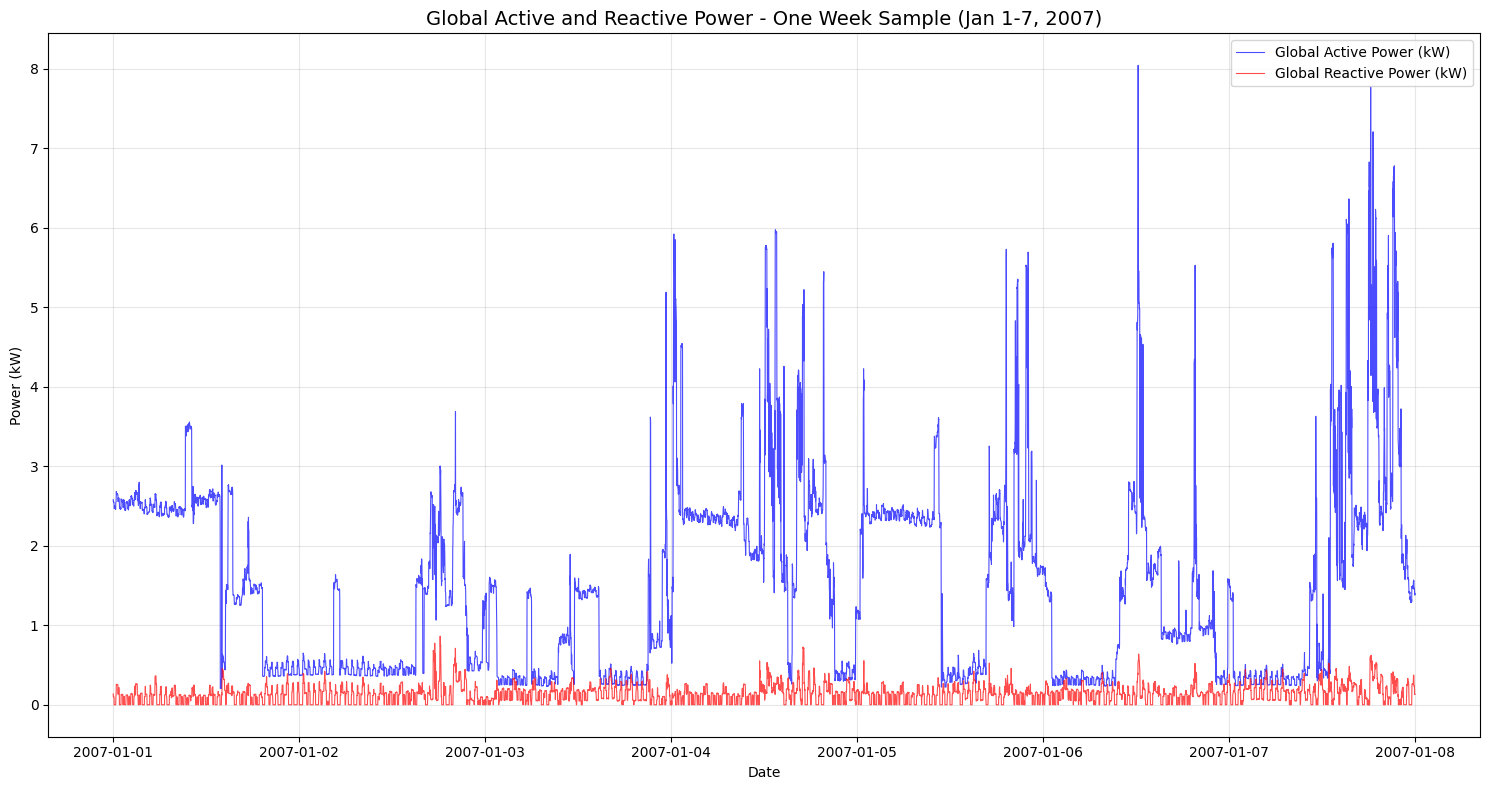


Sample week statistics:

Active Power:
count    10080.000000
mean         1.484233
std          1.189513
min          0.204000
25%          0.396000
50%          1.378000
75%          2.376000
max          8.044000
Name: Global_active_power, dtype: float64

Reactive Power:
count    10080.000000
mean         0.133825
std          0.112614
min          0.000000
25%          0.048000
50%          0.134000
75%          0.188000
max          0.862000
Name: Global_reactive_power, dtype: float64


In [6]:
# Sample a subset for faster plotting (1 week of data)
sample_start = '2007-01-01'
sample_end = '2007-01-07'
df_week = df_clean[sample_start:sample_end]

print(f"Sample period: {sample_start} to {sample_end}")
print(f"Sample size: {len(df_week)} records")

# Plot both active and reactive power superimposed
fig, ax = plt.subplots(figsize=(15, 8))

# Plot global active power
ax.plot(df_week.index, df_week['Global_active_power'], 
        linewidth=0.8, alpha=0.7, color='blue', label='Global Active Power (kW)')

# Plot global reactive power
ax.plot(df_week.index, df_week['Global_reactive_power'], 
        linewidth=0.8, alpha=0.7, color='red', label='Global Reactive Power (kW)')

ax.set_title('Global Active and Reactive Power - One Week Sample (Jan 1-7, 2007)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('Power (kW)')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Summary statistics for both
print("\nSample week statistics:")
print("\nActive Power:")
print(df_week['Global_active_power'].describe())
print("\nReactive Power:")
print(df_week['Global_reactive_power'].describe())

## Seasonality Analysis

Understanding seasonal patterns is crucial for energy forecasting. Let's analyze different types of seasonality in our data:

In [7]:
# Resample data for different time granularities
# Hourly averages
df_hourly = df_clean.resample('H').mean()
print(f"Hourly data shape: {df_hourly.shape}")

# Daily averages  
df_daily = df_clean.resample('D').mean()
print(f"Daily data shape: {df_daily.shape}")

# Weekly averages
df_weekly = df_clean.resample('W').mean()
print(f"Weekly data shape: {df_weekly.shape}")

# Monthly averages
df_monthly = df_clean.resample('M').mean()
print(f"Monthly data shape: {df_monthly.shape}")

print(f"\nDate range: {df_clean.index.min()} to {df_clean.index.max()}")
print(f"Total duration: {(df_clean.index.max() - df_clean.index.min()).days} days")

Hourly data shape: (34589, 7)
Daily data shape: (1442, 7)
Weekly data shape: (207, 7)
Monthly data shape: (48, 7)

Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Total duration: 1441 days
Daily data shape: (1442, 7)
Weekly data shape: (207, 7)
Monthly data shape: (48, 7)

Date range: 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Total duration: 1441 days


### Daily Seasonality (24-hour cycle)

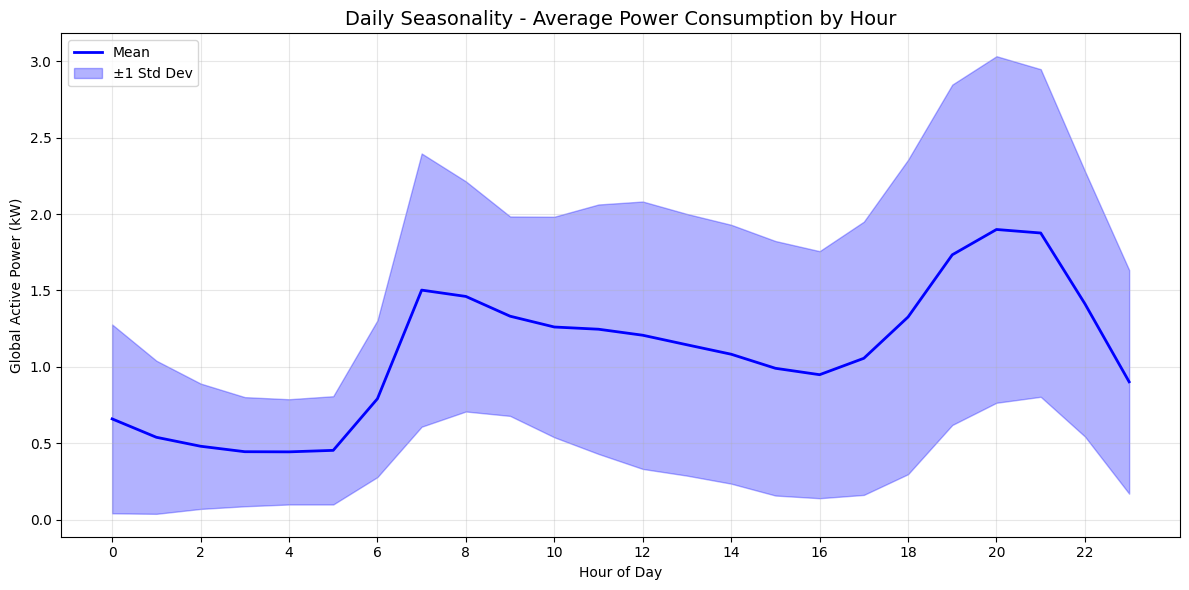

Daily pattern statistics:
Peak hour: 20:00
Lowest hour: 04:00
Peak consumption: 1.899 kW
Minimum consumption: 0.444 kW
Daily variation: 1.455 kW


In [8]:
# Analyze daily patterns (average consumption by hour of day)
df_hourly['hour'] = df_hourly.index.hour
daily_pattern = df_hourly.groupby('hour')['Global_active_power'].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

# Plot mean with error bars
ax.plot(daily_pattern['hour'], daily_pattern['mean'], 'b-', linewidth=2, label='Mean')
ax.fill_between(daily_pattern['hour'], 
                daily_pattern['mean'] - daily_pattern['std'],
                daily_pattern['mean'] + daily_pattern['std'],
                alpha=0.3, color='blue', label='±1 Std Dev')

ax.set_title('Daily Seasonality - Average Power Consumption by Hour', fontsize=14)
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Global Active Power (kW)')
ax.set_xticks(range(0, 24, 2))
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("Daily pattern statistics:")
print(f"Peak hour: {daily_pattern.loc[daily_pattern['mean'].idxmax(), 'hour']:02d}:00")
print(f"Lowest hour: {daily_pattern.loc[daily_pattern['mean'].idxmin(), 'hour']:02d}:00")
print(f"Peak consumption: {daily_pattern['mean'].max():.3f} kW")
print(f"Minimum consumption: {daily_pattern['mean'].min():.3f} kW")
print(f"Daily variation: {(daily_pattern['mean'].max() - daily_pattern['mean'].min()):.3f} kW")

### Weekly Seasonality (7-day cycle)

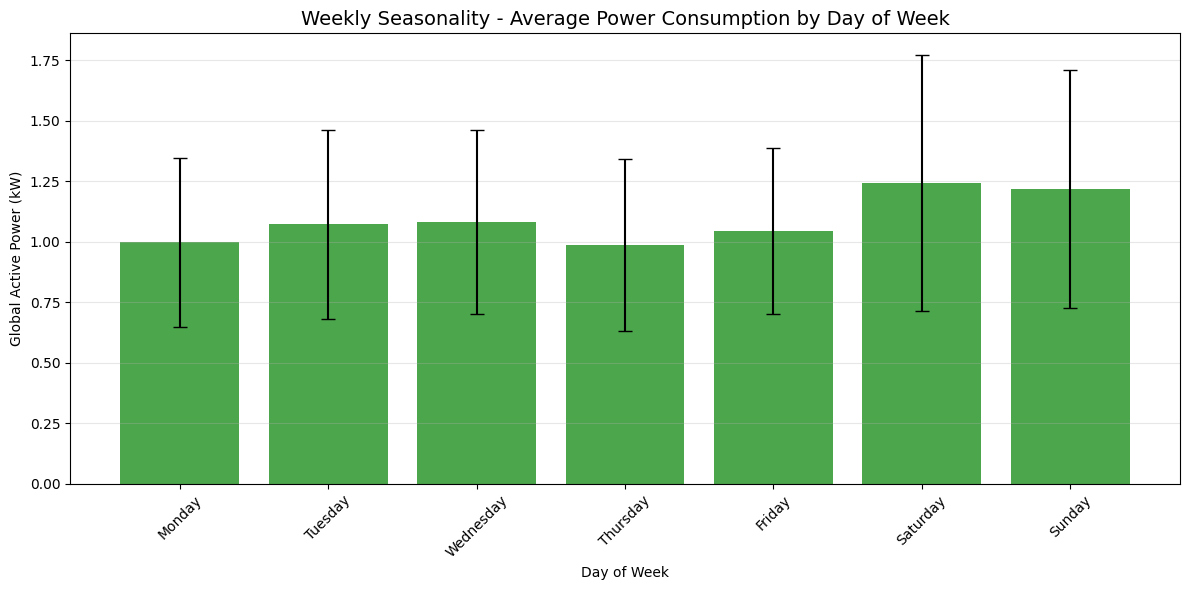

Weekly pattern statistics:
Highest consumption day: Saturday (1.244 kW)
Lowest consumption day: Thursday (0.986 kW)
Weekly variation: 0.258 kW


In [9]:
# Analyze weekly patterns (average consumption by day of week)
df_daily['dayofweek'] = df_daily.index.dayofweek
df_daily['day_name'] = df_daily.index.day_name()

weekly_pattern = df_daily.groupby(['dayofweek', 'day_name'])['Global_active_power'].agg(['mean', 'std']).reset_index()

fig, ax = plt.subplots(figsize=(12, 6))

# Plot weekly pattern
bars = ax.bar(weekly_pattern['day_name'], weekly_pattern['mean'], 
              yerr=weekly_pattern['std'], capsize=5, alpha=0.7, color='green')
ax.set_title('Weekly Seasonality - Average Power Consumption by Day of Week', fontsize=14)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Global Active Power (kW)')
ax.grid(True, alpha=0.3, axis='y')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Weekly pattern statistics:")
max_day = weekly_pattern.loc[weekly_pattern['mean'].idxmax()]
min_day = weekly_pattern.loc[weekly_pattern['mean'].idxmin()]

print(f"Highest consumption day: {max_day['day_name']} ({max_day['mean']:.3f} kW)")
print(f"Lowest consumption day: {min_day['day_name']} ({min_day['mean']:.3f} kW)")
print(f"Weekly variation: {(weekly_pattern['mean'].max() - weekly_pattern['mean'].min()):.3f} kW")

### Monthly/Seasonal Patterns

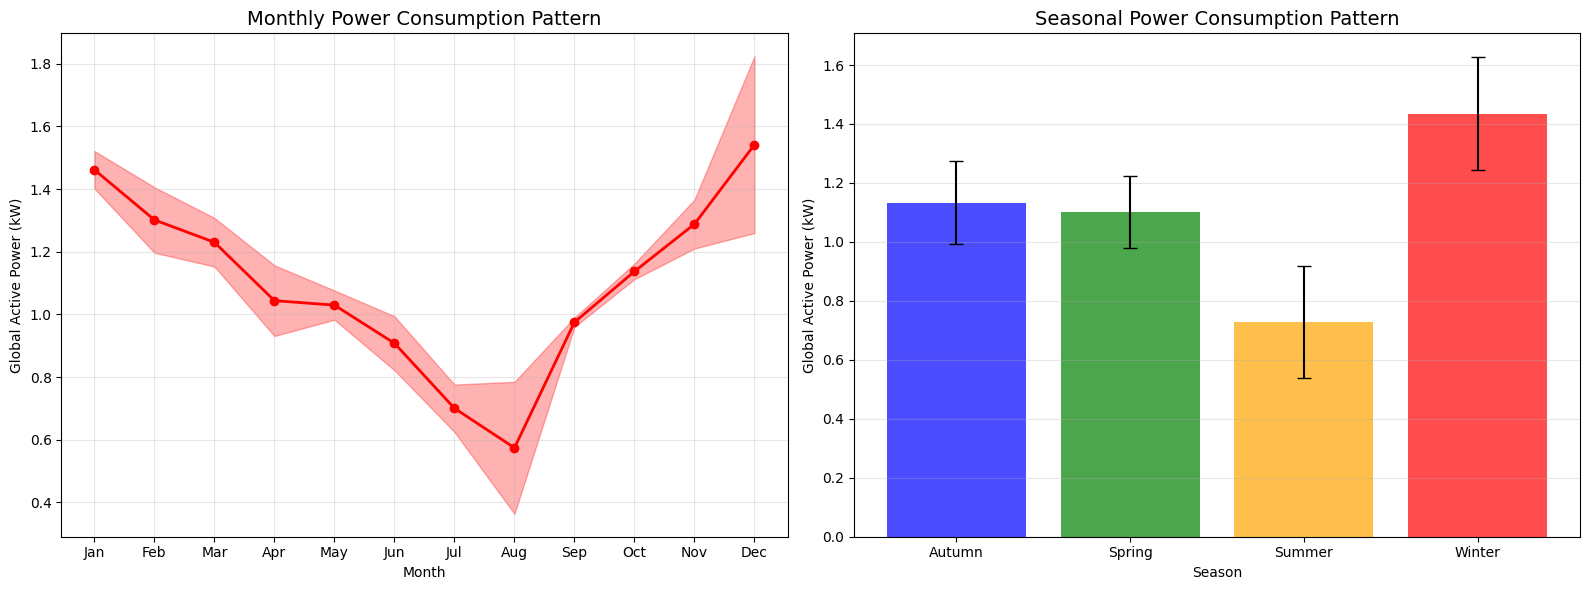

Monthly/Seasonal pattern statistics:
Highest consumption month: Dec (1.542 kW)
Lowest consumption month: Aug (0.574 kW)
Highest consumption season: Winter (1.435 kW)
Lowest consumption season: Summer (0.727 kW)


In [10]:
# Analyze monthly and seasonal patterns
df_monthly['month'] = df_monthly.index.month
df_monthly['year'] = df_monthly.index.year
df_monthly['season'] = df_monthly['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

# Monthly pattern
monthly_pattern = df_monthly.groupby('month')['Global_active_power'].agg(['mean', 'std'])
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Seasonal pattern
seasonal_pattern = df_monthly.groupby('season')['Global_active_power'].agg(['mean', 'std'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Monthly plot
ax1.plot(monthly_pattern.index, monthly_pattern['mean'], 'ro-', linewidth=2, markersize=6)
ax1.fill_between(monthly_pattern.index, 
                 monthly_pattern['mean'] - monthly_pattern['std'],
                 monthly_pattern['mean'] + monthly_pattern['std'],
                 alpha=0.3, color='red')
ax1.set_title('Monthly Power Consumption Pattern', fontsize=14)
ax1.set_xlabel('Month')
ax1.set_ylabel('Global Active Power (kW)')
ax1.set_xticks(range(1, 13))
ax1.set_xticklabels(month_names)
ax1.grid(True, alpha=0.3)

# Seasonal plot
colors = ['blue', 'green', 'orange', 'red']
bars = ax2.bar(seasonal_pattern.index, seasonal_pattern['mean'], 
               yerr=seasonal_pattern['std'], capsize=5, alpha=0.7, color=colors)
ax2.set_title('Seasonal Power Consumption Pattern', fontsize=14)
ax2.set_xlabel('Season')
ax2.set_ylabel('Global Active Power (kW)')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Monthly/Seasonal pattern statistics:")
print(f"Highest consumption month: {month_names[monthly_pattern['mean'].idxmax()-1]} ({monthly_pattern['mean'].max():.3f} kW)")
print(f"Lowest consumption month: {month_names[monthly_pattern['mean'].idxmin()-1]} ({monthly_pattern['mean'].min():.3f} kW)")

max_season = seasonal_pattern['mean'].idxmax()
min_season = seasonal_pattern['mean'].idxmin()
print(f"Highest consumption season: {max_season} ({seasonal_pattern.loc[max_season, 'mean']:.3f} kW)")
print(f"Lowest consumption season: {min_season} ({seasonal_pattern.loc[min_season, 'mean']:.3f} kW)")

### Seasonal Decomposition

#### Understanding Seasonal Decomposition

**What is Statsmodels?**

Statsmodels is a comprehensive Python library for statistical modeling and econometrics. It provides:
- **Statistical Models**: Regression, ARIMA, VAR, and more
- **Time Series Analysis**: Advanced tools for temporal data analysis
- **Statistical Tests**: Hypothesis testing, diagnostics, and validation
- **Econometric Tools**: Specialized methods for economic data analysis

**What is Seasonal Decomposition?**

Seasonal decomposition breaks down a time series into its fundamental components:

1. **Trend (T)**: Long-term direction or movement in the data
2. **Seasonal (S)**: Regular, predictable patterns that repeat over fixed periods
3. **Residual/Noise (R)**: Random fluctuations and irregular variations

**Decomposition Models:**

- **Additive Model**: `Y(t) = Trend(t) + Seasonal(t) + Residual(t)`
  - Seasonal fluctuations are relatively constant over time
  - Good when seasonal variations don't change much with the level of the time series

- **Multiplicative Model**: `Y(t) = Trend(t) × Seasonal(t) × Residual(t)`
  - Seasonal fluctuations change proportionally with the trend
  - Good when seasonal variations change with the level of the time series

**Time Series Analysis (TSA) Decomposition Benefits:**

- **Pattern Identification**: Clearly separates different types of variation
- **Trend Analysis**: Isolates long-term changes from noise
- **Seasonality Understanding**: Quantifies seasonal effects
- **Forecasting Preparation**: Provides components for model building
- **Anomaly Detection**: Residuals highlight unusual events
- **Business Insights**: Helps understand underlying drivers

For energy consumption data, decomposition helps identify:
- **Trend**: Changes in overall consumption over years
- **Seasonal**: Annual patterns (heating/cooling seasons)
- **Daily/Weekly**: Regular usage patterns
- **Anomalies**: Unusual consumption events

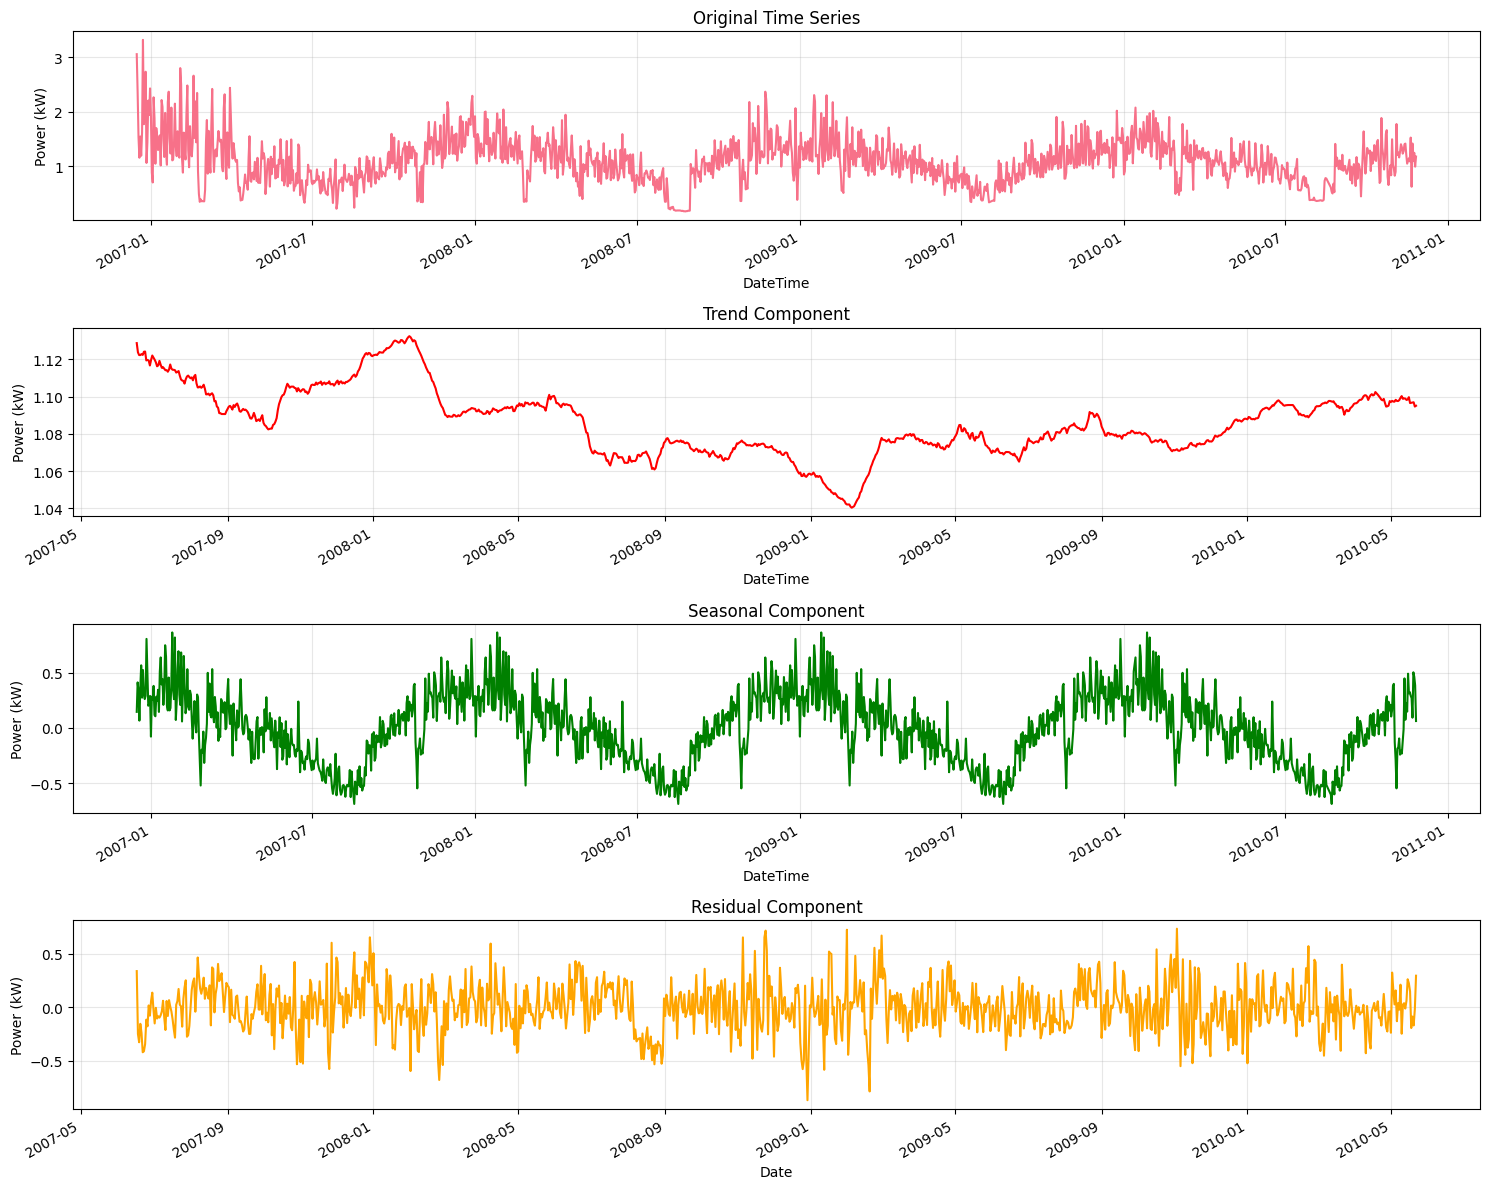

Seasonal Decomposition Statistics:
Trend variation: 0.018 kW
Seasonal variation: 0.314 kW
Residual variation: 0.226 kW
Seasonal contribution: 74.7%
Trend contribution: 4.3%


In [11]:
# Seasonal decomposition using statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

# Use daily data for decomposition (more manageable than hourly)
# Remove missing values for decomposition
df_daily_clean = df_daily['Global_active_power'].dropna()

# Perform seasonal decomposition with yearly period (365 days)
decomposition = seasonal_decompose(df_daily_clean, model='additive', period=365)

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

# Original data
decomposition.observed.plot(ax=axes[0], title='Original Time Series')
axes[0].set_ylabel('Power (kW)')

# Trend
decomposition.trend.plot(ax=axes[1], title='Trend Component', color='red')
axes[1].set_ylabel('Power (kW)')

# Seasonal
decomposition.seasonal.plot(ax=axes[2], title='Seasonal Component', color='green')
axes[2].set_ylabel('Power (kW)')

# Residual
decomposition.resid.plot(ax=axes[3], title='Residual Component', color='orange')
axes[3].set_ylabel('Power (kW)')
axes[3].set_xlabel('Date')

for ax in axes:
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print decomposition statistics
print("Seasonal Decomposition Statistics:")
print(f"Trend variation: {decomposition.trend.std():.3f} kW")
print(f"Seasonal variation: {decomposition.seasonal.std():.3f} kW") 
print(f"Residual variation: {decomposition.resid.std():.3f} kW")
print(f"Seasonal contribution: {(decomposition.seasonal.std() / df_daily_clean.std() * 100):.1f}%")
print(f"Trend contribution: {(decomposition.trend.std() / df_daily_clean.std() * 100):.1f}%")

## Correlation Analysis for Seasonality and Lag Selection

Correlation analysis is essential for:
- **Autocorrelation**: Identifying seasonal patterns and cycles in the data
- **Cross-correlation**: Understanding relationships between different variables
- **Lag Selection**: Determining optimal lookback periods for forecasting models
- **Feature Engineering**: Selecting relevant lagged variables for model inputs

### Autocorrelation Analysis

In [12]:
# Import additional libraries for correlation analysis
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import scipy.stats as stats

# Use hourly data for autocorrelation analysis (good balance between detail and computation)
# Take a sample period for manageable computation
sample_data = df_hourly['Global_active_power'].dropna()['2007-01-01':'2007-12-31']

print(f"Analyzing autocorrelation for: {len(sample_data)} hourly observations in 2007")
print(f"Data range: {sample_data.index.min()} to {sample_data.index.max()}")

# Calculate autocorrelation function (ACF) and partial autocorrelation function (PACF)
# ACF shows correlation between observations and their lags
# PACF shows direct correlation, removing indirect effects

# Calculate for up to 7 days for daily/weekly analysis
max_lags_short = 7 * 24  # 7 days * 24 hours for daily/weekly analysis

# Check data length and adjust accordingly
data_length = len(sample_data)
max_possible_lags = min(data_length // 4, max_lags_short)  # Use at most 1/4 of data length

print(f"Data length: {data_length} hours")
print(f"Maximum possible lags: {max_possible_lags} hours ({max_possible_lags/24:.1f} days)")

# Use shorter lag for detailed analysis
max_lags = min(max_lags_short, max_possible_lags)

# Compute ACF and PACF for short-term analysis
acf_values = acf(sample_data, nlags=max_lags)  # No confidence intervals
pacf_values = pacf(sample_data, nlags=max_lags)

print(f"Computed ACF and PACF for {max_lags} lags ({max_lags/24:.1f} days)")

Analyzing autocorrelation for: 8698 hourly observations in 2007
Data range: 2007-01-01 00:00:00 to 2007-12-31 23:00:00
Data length: 8698 hours
Maximum possible lags: 168 hours (7.0 days)
Computed ACF and PACF for 168 lags (7.0 days)


#### Understanding ACF and PACF Function Returns

**What does the `acf()` function return?**

The `acf()` function from statsmodels returns an array of autocorrelation coefficients:

- **Length**: `nlags + 1` (includes lag 0, which is always 1.0)
- **Values range**: -1 to 1
- **Each value**: Represents correlation between the series and its lag

**Interpretation:**
- **Lag 0**: Always 1.0 (perfect correlation with itself)
- **Positive values**: Series tends to be above average when it was above average at the lag
- **Negative values**: Series tends to be below average when it was above average at the lag
- **Values near 0**: Little to no linear relationship at that lag

**PACF (Partial Autocorrelation) differences:**
- Controls for correlations at intermediate lags
- Shows direct relationship between current value and specific lag
- Useful for identifying appropriate lag orders for AR models

In [13]:
# Let's examine the structure of ACF and PACF returns in detail
print("ACF Function Return Structure:")
print("=" * 40)

print(f"Type of acf_values: {type(acf_values)}")
print(f"Shape: {acf_values.shape}")

print(f"\nAutocorrelation coefficients:")
print(f"   - Shape: {acf_values.shape}")
print(f"   - Type: {type(acf_values)}")
print(f"   - First 10 values: {acf_values[:10].round(3)}")
print(f"   - Lag 0 (self-correlation): {acf_values[0]:.1f}")
print(f"   - Lag 1 (1-hour lag): {acf_values[1]:.3f}")
print(f"   - Lag 24 (24-hour lag): {acf_values[24]:.3f}")

print(f"\nKey seasonal lags:")
seasonal_lags = [1, 6, 12, 24, 48, 72, 168]  # 1h, 6h, 12h, 1d, 2d, 3d, 1w
for lag in seasonal_lags:
    if lag < len(acf_values):
        acf_val = acf_values[lag]
        print(f"   Lag {lag:3d} ({lag//24:2.0f}d {lag%24:2.0f}h): ACF = {acf_val:6.3f}")

print(f"\nNote: ACF values show the strength of correlation at each lag.")
print(f"Higher absolute values indicate stronger predictive relationships at those time lags.")

ACF Function Return Structure:
Type of acf_values: <class 'numpy.ndarray'>
Shape: (169,)

Autocorrelation coefficients:
   - Shape: (169,)
   - Type: <class 'numpy.ndarray'>
   - First 10 values: [1.    0.727 0.483 0.301 0.162 0.078 0.029 0.006 0.023 0.079]
   - Lag 0 (self-correlation): 1.0
   - Lag 1 (1-hour lag): 0.727
   - Lag 24 (24-hour lag): 0.439

Key seasonal lags:
   Lag   1 ( 0d  1h): ACF =  0.727
   Lag   6 ( 0d  6h): ACF =  0.029
   Lag  12 ( 0d 12h): ACF =  0.249
   Lag  24 ( 1d  0h): ACF =  0.439
   Lag  48 ( 2d  0h): ACF =  0.397
   Lag  72 ( 3d  0h): ACF =  0.406
   Lag 168 ( 7d  0h): ACF =  0.427

Note: ACF values show the strength of correlation at each lag.
Higher absolute values indicate stronger predictive relationships at those time lags.


Now we'll use the `plot_acf()` and `plot_pacf()` functions from statsmodels to visualize the autocorrelation results and create a manual plot using our calculated ACF values for comparison.

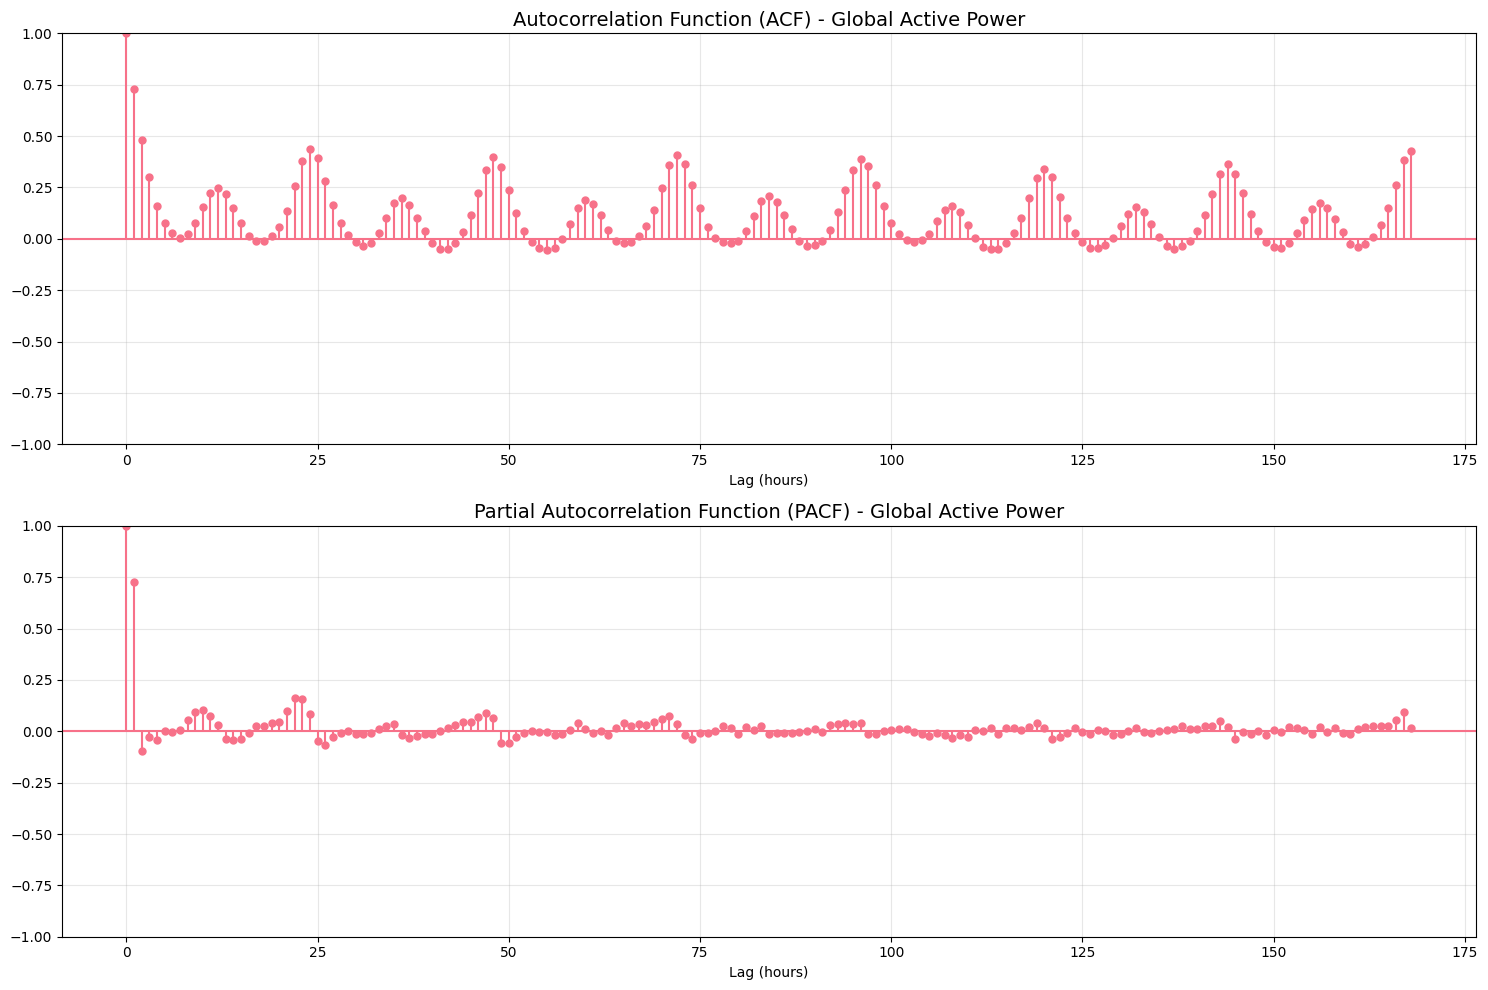


Significant ACF lags (seasonal patterns - |ACF| > 0.1):
  Lag  24 hours (1.0 days):  0.439
  Lag 168 hours (7.0 days):  0.427
  Lag  72 hours (3.0 days):  0.406
  Lag  48 hours (2.0 days):  0.397
  Lag  96 hours (4.0 days):  0.390

Key seasonal periods identified:
  Daily cycle: 24 hours (ACF = 0.439)
  Weekly cycle: 168 hours (7.0 days, ACF = 0.427)


In [14]:
# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: ACF (without confidence intervals)
plot_acf(sample_data, lags=max_lags, ax=ax1, alpha=None)
ax1.set_title('Autocorrelation Function (ACF) - Global Active Power', fontsize=14)
ax1.set_xlabel('Lag (hours)')
ax1.grid(True, alpha=0.3)

# Plot 2: PACF (without confidence intervals)
plot_pacf(sample_data, lags=max_lags, ax=ax2, alpha=None)
ax2.set_title('Partial Autocorrelation Function (PACF) - Global Active Power', fontsize=14)
ax2.set_xlabel('Lag (hours)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify significant seasonal lags based on magnitude
acf_significant = []
pacf_significant = []

# Check for strong autocorrelations (using magnitude threshold)
for i, acf_val in enumerate(acf_values):
    if i > 0 and abs(acf_val) > 0.1:  # Threshold for practical significance
        acf_significant.append((i, acf_val))

for i, pacf_val in enumerate(pacf_values):
    if i > 0 and abs(pacf_val) > 0.1:  # Threshold for practical significance
        pacf_significant.append((i, pacf_val))

print("\nSignificant ACF lags (seasonal patterns - |ACF| > 0.1):")
# Sort by absolute correlation value to get the strongest correlations first
acf_significant_sorted = sorted(acf_significant, key=lambda x: abs(x[1]), reverse=True)
for lag, value in acf_significant_sorted[:10]:  # Show top 10 by magnitude
    if lag in [24, 48, 72, 96, 120, 144, 168]:  # Daily/weekly patterns
        print(f"  Lag {lag:3d} hours ({lag//24:2.1f} days): {value:6.3f}")

print("\nKey seasonal periods identified:")
# Find the strongest correlations in daily and weekly ranges
daily_candidates = [(lag, value) for lag, value in acf_significant if lag in range(20, 28)]  # Around 24 hours
weekly_candidates = [(lag, value) for lag, value in acf_significant if lag in range(160, 176)]  # Around 168 hours (7 days)

# Sort by absolute correlation value to get the strongest
if daily_candidates:
    strongest_daily = max(daily_candidates, key=lambda x: abs(x[1]))
    print(f"  Daily cycle: {strongest_daily[0]} hours (ACF = {strongest_daily[1]:.3f})")
    
if weekly_candidates:
    strongest_weekly = max(weekly_candidates, key=lambda x: abs(x[1]))
    print(f"  Weekly cycle: {strongest_weekly[0]} hours ({strongest_weekly[0]/24:.1f} days, ACF = {strongest_weekly[1]:.3f})")

### Cross-Correlation Analysis

Cross-correlation analysis for 8698 observations
Variables: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']


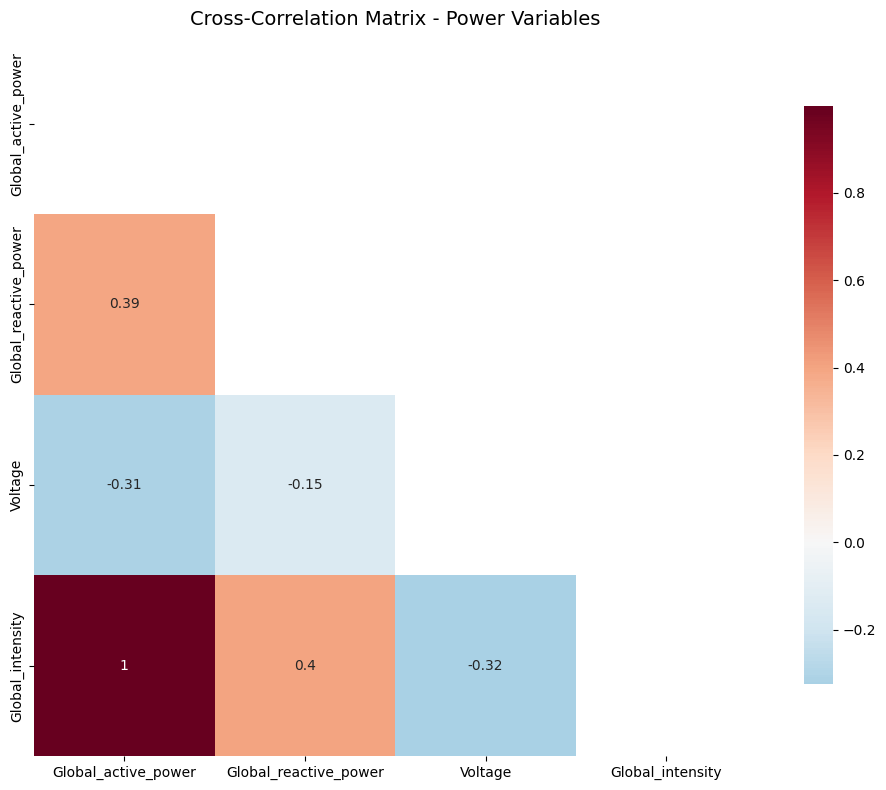


Correlation Matrix:
                       Global_active_power  Global_reactive_power  Voltage  \
Global_active_power                  1.000                  0.390   -0.311   
Global_reactive_power                0.390                  1.000   -0.147   
Voltage                             -0.311                 -0.147    1.000   
Global_intensity                     1.000                  0.404   -0.324   

                       Global_intensity  
Global_active_power               1.000  
Global_reactive_power             0.404  
Voltage                          -0.324  
Global_intensity                  1.000  

Strong correlations (|r| > 0.7):
  Global_active_power ↔ Global_intensity:  1.000


In [15]:
# Cross-correlation between different power variables
# Analyze relationships between Global Active Power and other variables

# Select variables for cross-correlation
variables = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity']
sample_hourly = df_hourly[variables].dropna()['2007-01-01':'2007-12-31']

print(f"Cross-correlation analysis for {len(sample_hourly)} observations")
print("Variables:", variables)

# Calculate cross-correlation matrix (Pearson correlation)
correlation_matrix = sample_hourly.corr()

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, ax=ax, cbar_kws={'shrink': 0.8})
ax.set_title('Cross-Correlation Matrix - Power Variables', fontsize=14)
plt.tight_layout()
plt.show()

print("\nCorrelation Matrix:")
print(correlation_matrix.round(3))

# Identify strong correlations (|r| > 0.7)
strong_correlations = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            var1 = correlation_matrix.columns[i]
            var2 = correlation_matrix.columns[j]
            strong_correlations.append((var1, var2, corr_val))

print(f"\nStrong correlations (|r| > 0.7):")
for var1, var2, corr in strong_correlations:
    print(f"  {var1} ↔ {var2}: {corr:6.3f}")

### Sub-metering Correlation Analysis

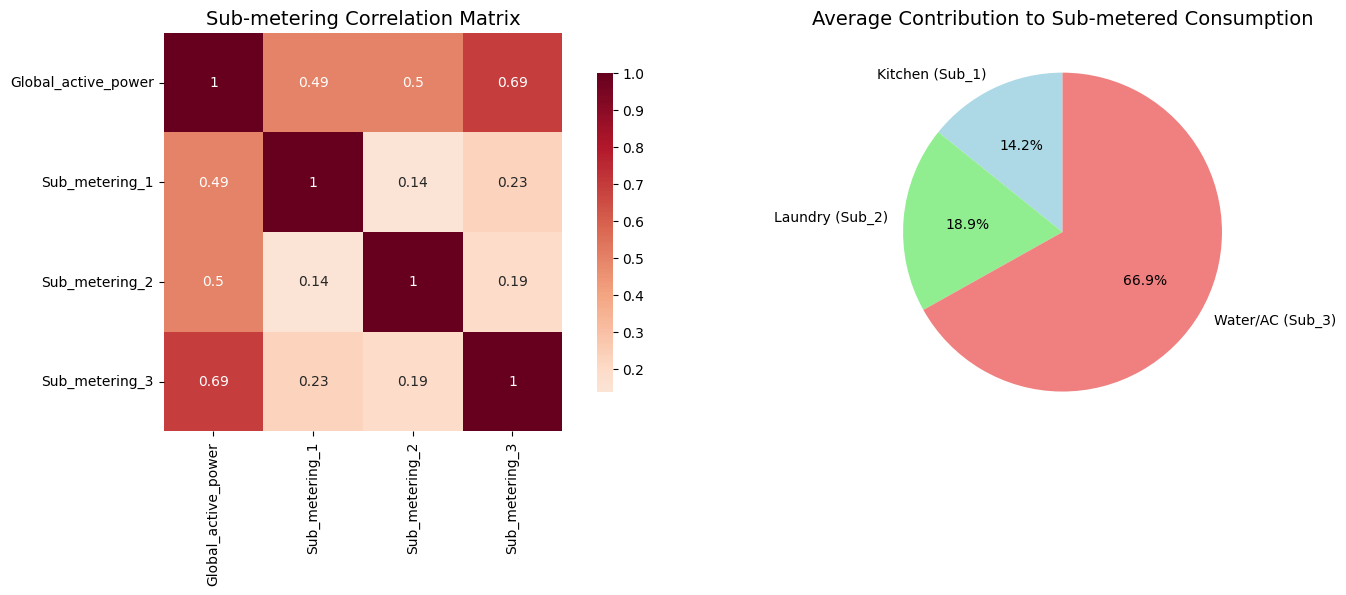

Sub-metering Correlation Analysis:

Correlations with Global Active Power:
  Sub_metering_1: r = 0.495
  Sub_metering_2: r = 0.499
  Sub_metering_3: r = 0.689

Sub-metering Statistics:
  Average total power: 1.117 kW
  Average sub-metered: 0.009 kW
  Sub-metered coverage: 0.8%

Mean consumption by appliance category:
  Kitchen (Sub_1): 1.2 Wh/hour
  Laundry (Sub_2): 1.6 Wh/hour
  Water/AC (Sub_3): 5.8 Wh/hour

Temporal correlation patterns:
Cross-correlations between sub-meters:
  Sub_metering_1 ↔ Sub_metering_2: r = 0.139
  Sub_metering_1 ↔ Sub_metering_3: r = 0.232
  Sub_metering_2 ↔ Sub_metering_3: r = 0.192


In [16]:
# Analyze correlations between sub-metering channels and total consumption
# This helps understand which appliances contribute most to total consumption patterns

sub_metering_vars = ['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
sub_sample = df_hourly[sub_metering_vars].dropna()['2007-01-01':'2007-12-31']

# Calculate correlation matrix for sub-metering
sub_corr_matrix = sub_sample.corr()

# Create a more detailed heatmap for sub-metering
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
sns.heatmap(sub_corr_matrix, annot=True, cmap='RdBu_r', center=0,
            square=True, ax=ax1, cbar_kws={'shrink': 0.8})
ax1.set_title('Sub-metering Correlation Matrix', fontsize=14)

# Contribution analysis - what percentage of total power each sub-meter represents
sub_sample['Total_submetering'] = (sub_sample['Sub_metering_1'] + 
                                   sub_sample['Sub_metering_2'] + 
                                   sub_sample['Sub_metering_3'])

# Convert from Watt-hour to kilowatt-hour for comparison
sub_sample['Total_submetering_kWh'] = sub_sample['Total_submetering'] / 1000

# Calculate contribution percentages
contributions = {
    'Kitchen (Sub_1)': sub_sample['Sub_metering_1'].mean() / sub_sample['Total_submetering'].mean() * 100,
    'Laundry (Sub_2)': sub_sample['Sub_metering_2'].mean() / sub_sample['Total_submetering'].mean() * 100,
    'Water/AC (Sub_3)': sub_sample['Sub_metering_3'].mean() / sub_sample['Total_submetering'].mean() * 100
}

# Plot contribution pie chart
ax2.pie(contributions.values(), labels=contributions.keys(), autopct='%1.1f%%', 
        startangle=90, colors=['lightblue', 'lightgreen', 'lightcoral'])
ax2.set_title('Average Contribution to Sub-metered Consumption', fontsize=14)

plt.tight_layout()
plt.show()

print("Sub-metering Correlation Analysis:")
print("\nCorrelations with Global Active Power:")
for var in ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    corr = sub_corr_matrix.loc['Global_active_power', var]
    print(f"  {var}: r = {corr:.3f}")

print(f"\nSub-metering Statistics:")
print(f"  Average total power: {sub_sample['Global_active_power'].mean():.3f} kW")
print(f"  Average sub-metered: {sub_sample['Total_submetering_kWh'].mean():.3f} kW")
print(f"  Sub-metered coverage: {(sub_sample['Total_submetering_kWh'].mean() / sub_sample['Global_active_power'].mean() * 100):.1f}%")

print(f"\nMean consumption by appliance category:")
for i, category in enumerate(['Kitchen', 'Laundry', 'Water/AC'], 1):
    mean_consumption = sub_sample[f'Sub_metering_{i}'].mean()
    print(f"  {category} (Sub_{i}): {mean_consumption:.1f} Wh/hour")

# Analyze temporal patterns in sub-metering
print(f"\nTemporal correlation patterns:")
print("Cross-correlations between sub-meters:")
sub_meters_only = ['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']
for i in range(len(sub_meters_only)):
    for j in range(i+1, len(sub_meters_only)):
        var1, var2 = sub_meters_only[i], sub_meters_only[j]
        corr = sub_corr_matrix.loc[var1, var2]
        print(f"  {var1} ↔ {var2}: r = {corr:.3f}")

## Summary and Key Findings

This notebook explored the UCI Individual Household Electric Power Consumption dataset, providing comprehensive insights for energy time series forecasting through data exploration, seasonality analysis, and correlation studies.

### Dataset Overview
- **Timeline**: December 2006 - November 2010 (47 months)
- **Frequency**: 1-minute measurements (~2.1M records)
- **Variables**: 9 features including power consumption, voltage, current, and sub-metering
- **Data Quality**: Some missing values (represented as '?') requiring preprocessing

### Key Observations

#### 1. **Data Characteristics**
- High-frequency time series with clear temporal patterns
- Missing values present, handled through conversion to NaN
- Multiple related variables suitable for multivariate forecasting

#### 2. **Power Consumption Patterns**
- **Active Power**: Shows strong daily cycles with typical household usage patterns
- **Reactive Power**: Lower magnitude, different temporal behavior
- Clear relationships between active and reactive power consumption

#### 3. **Seasonality Analysis**
- **Daily Patterns**: Clear 24-hour cycles with peak consumption during evening hours
- **Weekly Patterns**: Distinct weekday vs. weekend consumption differences
- **Monthly/Seasonal**: Seasonal variations with higher consumption in winter months
- **Decomposition**: Successfully separated trend, seasonal, and residual components

#### 4. **Correlation Analysis**
- **Autocorrelation**: Strong correlations at 24-hour (daily) and 168-hour (weekly) lags
- **Cross-correlation**: High correlations between Global Active Power and Global Intensity
- **Sub-metering**: Kitchen appliances show highest correlation with total consumption

### Forecasting Implications

This dataset demonstrates:

1. **Real-world complexity**: Actual household consumption with noise and irregularities
2. **Multiple seasonality**: Daily, weekly, and annual patterns for multi-scale modeling
3. **Rich temporal patterns**: Clear autocorrelation structure for sequence modeling
4. **Preprocessing challenges**: Missing data, type conversions, datetime handling
5. **Multivariate opportunities**: Strong relationships between different power measurements

### Model Design Recommendations

Based on the analysis, forecasting models should incorporate:

- **Sequence Length**: 24-168 hour lookback windows to capture daily and weekly patterns
- **Multivariate Inputs**: Include Global Intensity and sub-metering as auxiliary features
- **Temporal Features**: Hour, day of week, month, and seasonal indicators

### Next Steps

The cleaned and explored dataset is now ready for:

1. **Feature Engineering**: Create lag variables, rolling statistics, and temporal features
2. **Baseline Models**: Implement statistical forecasting models (ARIMA, seasonal naive)
3. **Deep Learning Models**: Develop LSTM, GRU, Transformer-based architectures
4. **Model Evaluation**: Compare performance using time-series specific metrics
5. **Hyperparameter Tuning**: Optimize based on correlation analysis insights

This comprehensive exploration provides a robust foundation for building energy consumption forecasting models.